In [ ]:
#############################################################################
# zlib License
#
# (C) 2023 Zach FLowers, Jongho Lee, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

## Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import pickle
import pandas
from pathlib import Path
import subprocess
from math import ceil
import sqlite3

## Specify board name

In [2]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_name = "ET2_W36_IP5-18"
# chip_figname = f"LowBiasCurrent_HVon100V_C26Removed_Ext10KOhm_{chip_name}"
# chip_figtitle= "LowBiasCurrent HVon100V C26Removed Ext10KOhm "+chip_name
# CblHVandGNDExtDouble
chip_figname = f"LowBiasCurrent_HVon100V_L7Removed_{chip_name}"
chip_figtitle= "LowBiasCurrent HVon100V L7Removed "+chip_name

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

## Set defaults

In [3]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [4]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [5]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [6]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

In [7]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

# Pixel ID Check

In [8]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [9]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

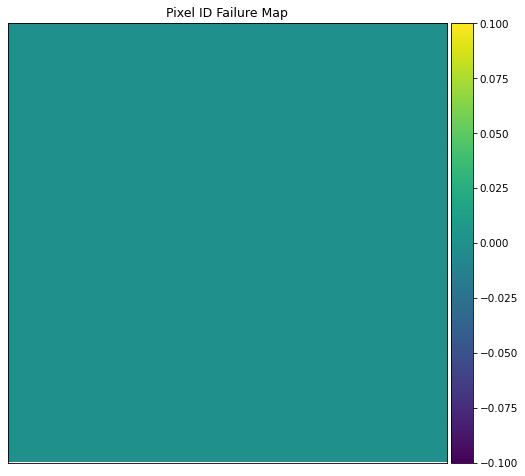

In [10]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")
plt.show()

## Set Peripheral Registers

In [11]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))
peripheral_decoded_register_write("singlePort", '1')
peripheral_decoded_register_write("serRateLeft", '00')
peripheral_decoded_register_write("serRateRight", '00')
peripheral_decoded_register_write("onChipL1AConf", '00')
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))
# peripheral_decoded_register_write("fcClkDelayEn", "1")

# Force Re-align of the FC

Run this when you see inconsistent BCID in your data, even though you expect to see the same numbers for each cycle

In [ ]:
print(peripheral_decoded_register_read("asyAlignFastcommand", "Config"))

peripheral_decoded_register_write("asyAlignFastcommand", "1")
peripheral_decoded_register_write("asyAlignFastcommand", "0")

### Disable all pixels

In [12]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")

### Define pixels of interest

In [13]:
# Sensor board pixels of interest
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]

row_list = [14, 14, 14, 14, 15, 15, 15, 15]
col_list = [6, 7, 8, 9, 6, 7, 8, 9]

scan_list = list(zip(col_list, row_list))
print(scan_list)

[(6, 14), (7, 14), (8, 14), (9, 14), (6, 15), (7, 15), (8, 15), (9, 15)]


## Automatic threshold calibration

In [14]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

In [15]:
data = []

row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x010, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        data += [{
            'col': col,
            'row': row,
            'baseline': BL_map_THCal[row, col],
            'noise_width': NW_map_THCal[row, col],
            'timestamp': datetime.datetime.now(),
            'chip_name': chip_name,
        }]
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        
        # pixel_decoded_register_write("DAC", format(0, '010b'))
        # pixel_decoded_register_write("Bypass_THCal", "1")
        time.sleep(0.1)

BL_df = pandas.DataFrame(data = data)

 row: 100%|██████████| 16/16 [02:04<00:00,  7.81s/it]


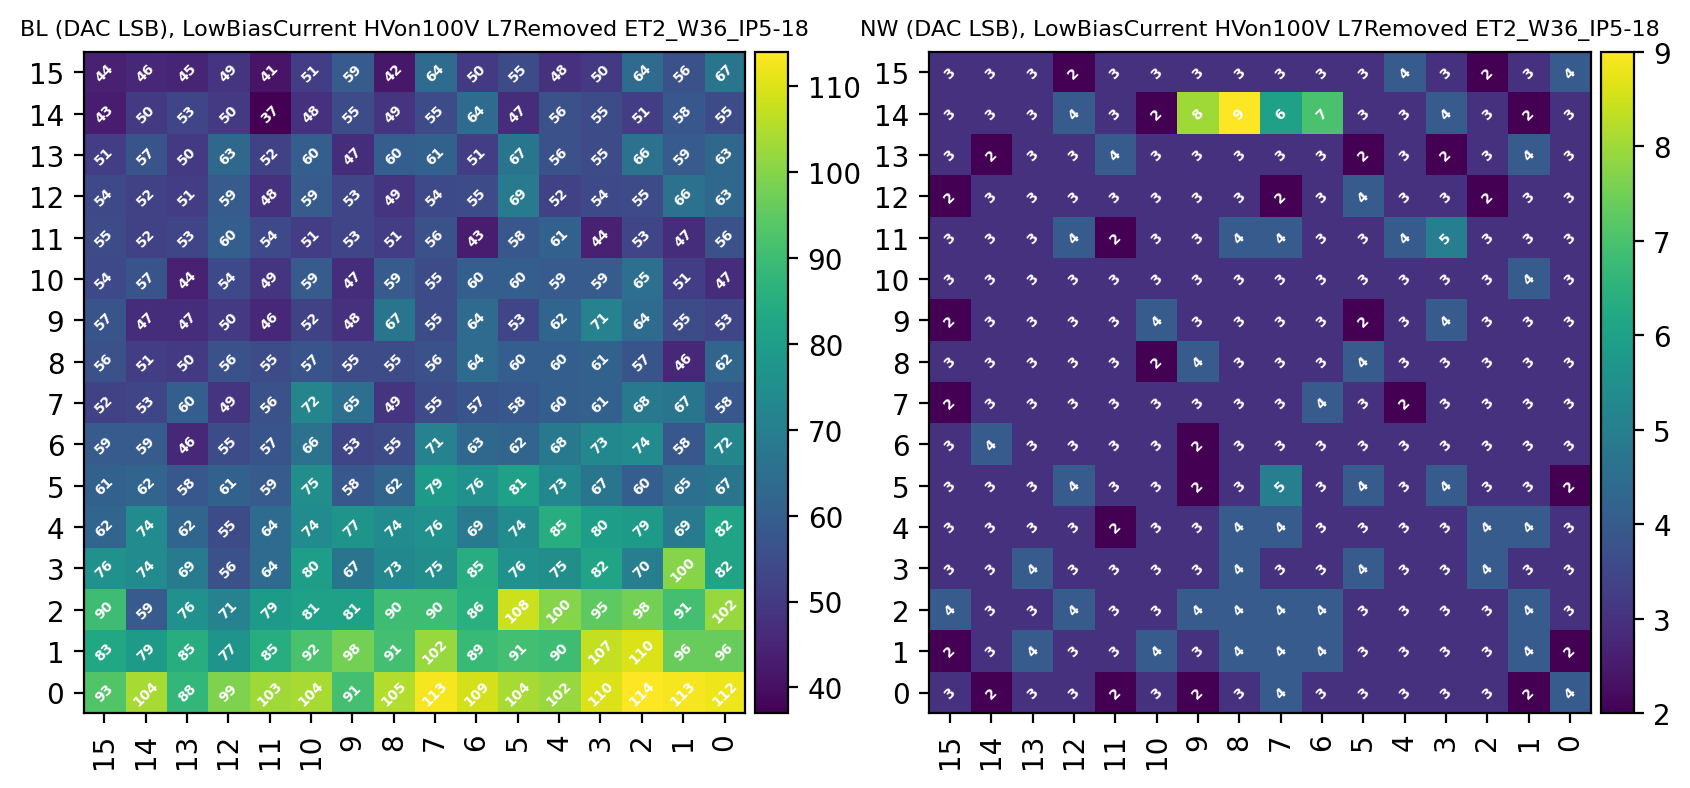

In [16]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB), "+chip_figtitle, size=8)
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB), "+chip_figtitle, size=8)
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
plt.savefig(str(fig_outdir)+"/BL_NW_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
# plt.show()

In [ ]:
new_columns = {
    'note': f'{chip_figname}',
}

for col in new_columns:
    BL_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'BaselineHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add BaselineHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in init_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    BL_df.to_sql('baselines', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in end_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

p.stdin.close()

print(p.stdout.read())


# ACC S-curve calibration

In [17]:
DAC_range = np.arange(0 ,100)
accdata = []

ACC_map_Scurve = {row:{col:np.zeros_like(DAC_range) for col in range(16)} for row in range(16)}
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for col, row in tqdm(scan_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Enable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "1")
    pixel_decoded_register_write("BufEn_THCal", "1")
    pixel_decoded_register_write("Bypass_THCal", "1")
    for index,DAC in enumerate(DAC_range):
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Set the DAC value to the value being scanned
        pixel_decoded_register_write("DAC", format(DAC, '010b'))
        # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        # time.sleep(.1)
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Fetch the status registers
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        ACC_map_Scurve[row][col][index] = pixel_decoded_register_read("ACC", "Status", need_int=True)
    
    accdata += [{
            'col': col,
            'row': row,
            'accscurve': ACC_map_Scurve[row][col],
            'xmin': np.amin(DAC_range),
            'xmax': np.amax(DAC_range)+1,
            'xstep': (np.amax(DAC_range)+1-np.amin(DAC_range))/DAC_range.size,
            'chip_name': chip_name,
            'timestamp': datetime.datetime.now(),
    }]
    
    # Disable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "0")
    pixel_decoded_register_write("BufEn_THCal", "0")
    # Set the DAC value to the vpreviously found BL + Offset (7)
    # pixel_decoded_register_write("DAC", format(int(BL_map_THCal[row,col]+7), '010b'))
    pixel_decoded_register_write("DAC", format(0, '010b'))
    time.sleep(0.1)

acc_df = pandas.DataFrame(data = accdata)
# Need to convert array to string, to save as SQL
acc_df['accscurve'] = acc_df['accscurve'].apply(lambda arr: ','.join(map(str, arr)))

100%|██████████| 8/8 [03:11<00:00, 23.91s/it]


In [ ]:
new_columns = {
    'note': f'{chip_figname}',
}

for col in new_columns:
    acc_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'ACCScurveHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add ACCScurveHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in init_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    acc_df.to_sql('acc_scurve', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

for cmd in end_cmd:
    p.stdin.write(cmd + "\n")
p.stdin.close()
p.wait()

p.stdin.close()

print(p.stdout.read())


## Comparing Auto-THCal with ACC S-curve

  0%|          | 0/8 [00:00<?, ?it/s]

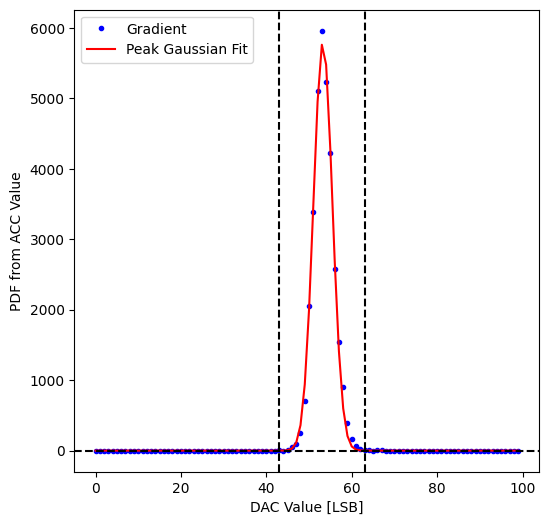

 12%|█▎        | 1/8 [00:00<00:00,  8.78it/s]

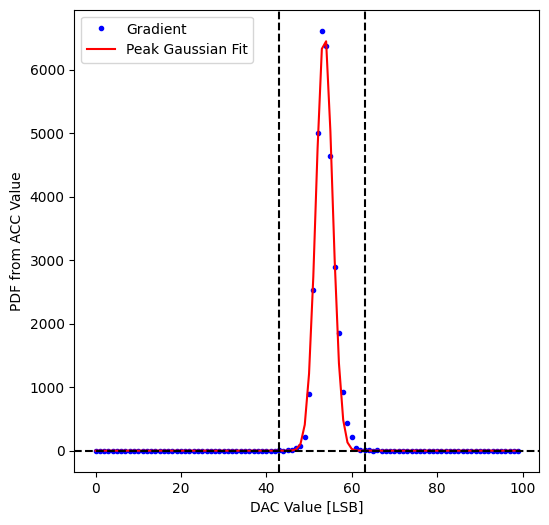

 25%|██▌       | 2/8 [00:00<00:00,  8.00it/s]

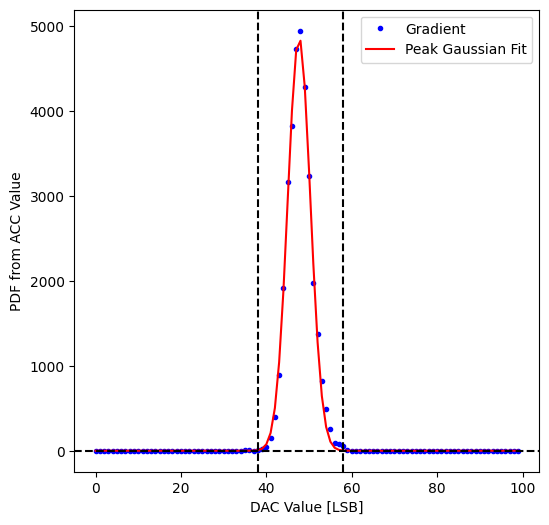

 38%|███▊      | 3/8 [00:00<00:00,  7.92it/s]

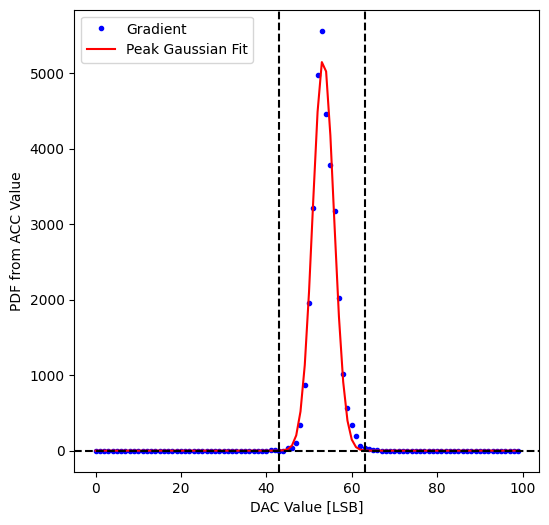

 50%|█████     | 4/8 [00:00<00:00,  7.90it/s]

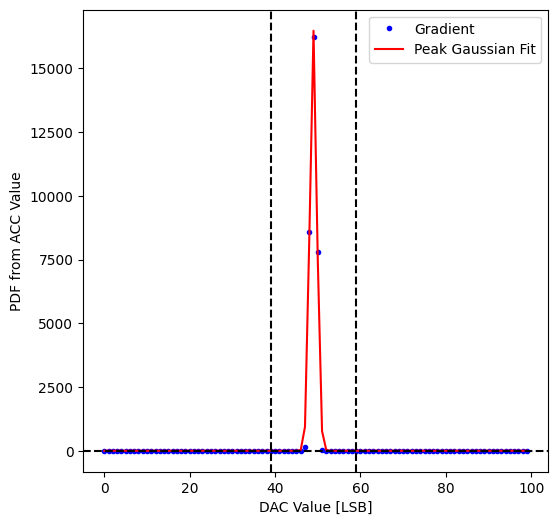

 62%|██████▎   | 5/8 [00:00<00:00,  7.60it/s]

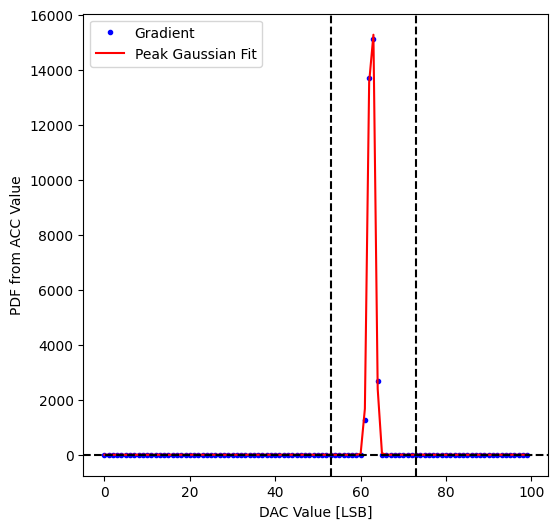

 75%|███████▌  | 6/8 [00:00<00:00,  7.84it/s]

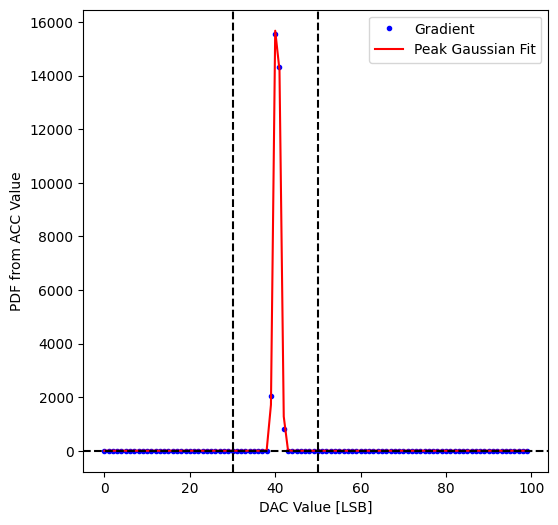

 88%|████████▊ | 7/8 [00:00<00:00,  7.89it/s]

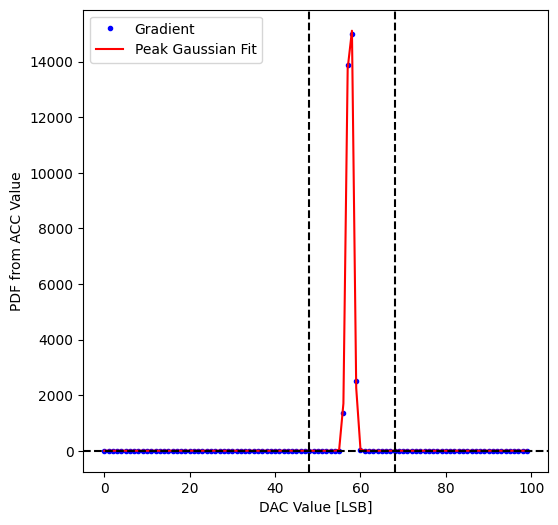

100%|██████████| 8/8 [00:01<00:00,  7.92it/s]


In [18]:
from scipy.optimize import curve_fit
from scipy.stats import crystalball, chisquare

# Define the composite Gaussian function
def composite_gaussian(x, a1, mean1, sigma1, a2, mean2, sigma2):
    gauss1 = a1 * np.exp(-(x - mean1) ** 2 / (2 * sigma1 ** 2))
    gauss2 = a2 * np.exp(-(x - mean2) ** 2 / (2 * sigma2 ** 2))
    return gauss1 + gauss2

def gaussian_func(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def cball_func(x, a, mu, sigma, alpha, n):
    return a * crystalball.pdf(x, n, alpha, mu, sigma)

def return_closest_xvalue(x, value):
    return np.argmin(np.abs(x - value))

GMean_map_THCal = np.zeros((16,16))
GSigma_map_THCal = np.zeros((16,16))
x = DAC_range

fit_width = 10

for col, row in tqdm(scan_list):
    y = ACC_map_Scurve[row][col]
    dy_dx = -1*np.gradient(y, x)
    max_index = np.argmax(dy_dx)
    selection = (dy_dx>0) & (x>=x[max_index]-fit_width) & (x<=x[max_index]+fit_width)

    initial_guess = [1.0, x[max_index], 1.0]
    initial_guess_cball = [30000, -1*x[max_index], 5, 5, 1]

    popt, pcov = curve_fit(gaussian_func, x[selection], dy_dx[selection], p0=initial_guess)
    # popt_cball, pcov_cball = curve_fit(cball_func, -1*x, dy_dx, p0=initial_guess_cball)
    a1_fit, mean1_fit, sigma1_fit = popt
    sigma1_fit = abs(sigma1_fit)
    GMean_map_THCal[row][col]  = mean1_fit
    GSigma_map_THCal[row][col] = sigma1_fit
    # _, mean_cball_fit, sigma_cball_fit,_,_ = popt_cball

    y_fit1 = gaussian_func(x, *popt)
    # y_cball_fit = cball_func(-1*x, *popt_cball)

    # Calculate R-squared value
    # ssr = np.sum((dy_dx - y_fit1) ** 2)
    # sst = np.sum((dy_dx - np.mean(y_fit1)) ** 2)
    # r_squared = 1 - (ssr / sst)
    # print('R squared:', r_squared)

    # Calculate the chi-square statistic
    # observed_values, _ = np.histogram(dy_dx, bins=len(x))
    # expected_values = gaussian_func(x, a1_fit, mean1_fit, sigma1_fit)
    # chi2, p_value = chisquare(observed_values, expected_values)
    # print('Chi-Square Statistic:', chi2, 'P-value:', p_value)

    # Plot the differentials
    fig = plt.figure(dpi=100, figsize=(6,6))
    plt.plot(x, dy_dx, 'b.', label='Gradient')
    plt.plot(x, y_fit1, color='r', linestyle='-', label='Peak Gaussian Fit')
    # plt.plot(x, y_cball_fit, color='g', linestyle='--', label='Crystal Ball')
    plt.axhline(0, ls='--', color='k')
    plt.axvline(x[max_index]-fit_width, ls='--', color='k')
    plt.axvline(x[max_index]+fit_width, ls='--', color='k')
    plt.xlabel("DAC Value [LSB]")
    plt.ylabel("PDF from ACC Value")
    plt.legend()
    plt.show()

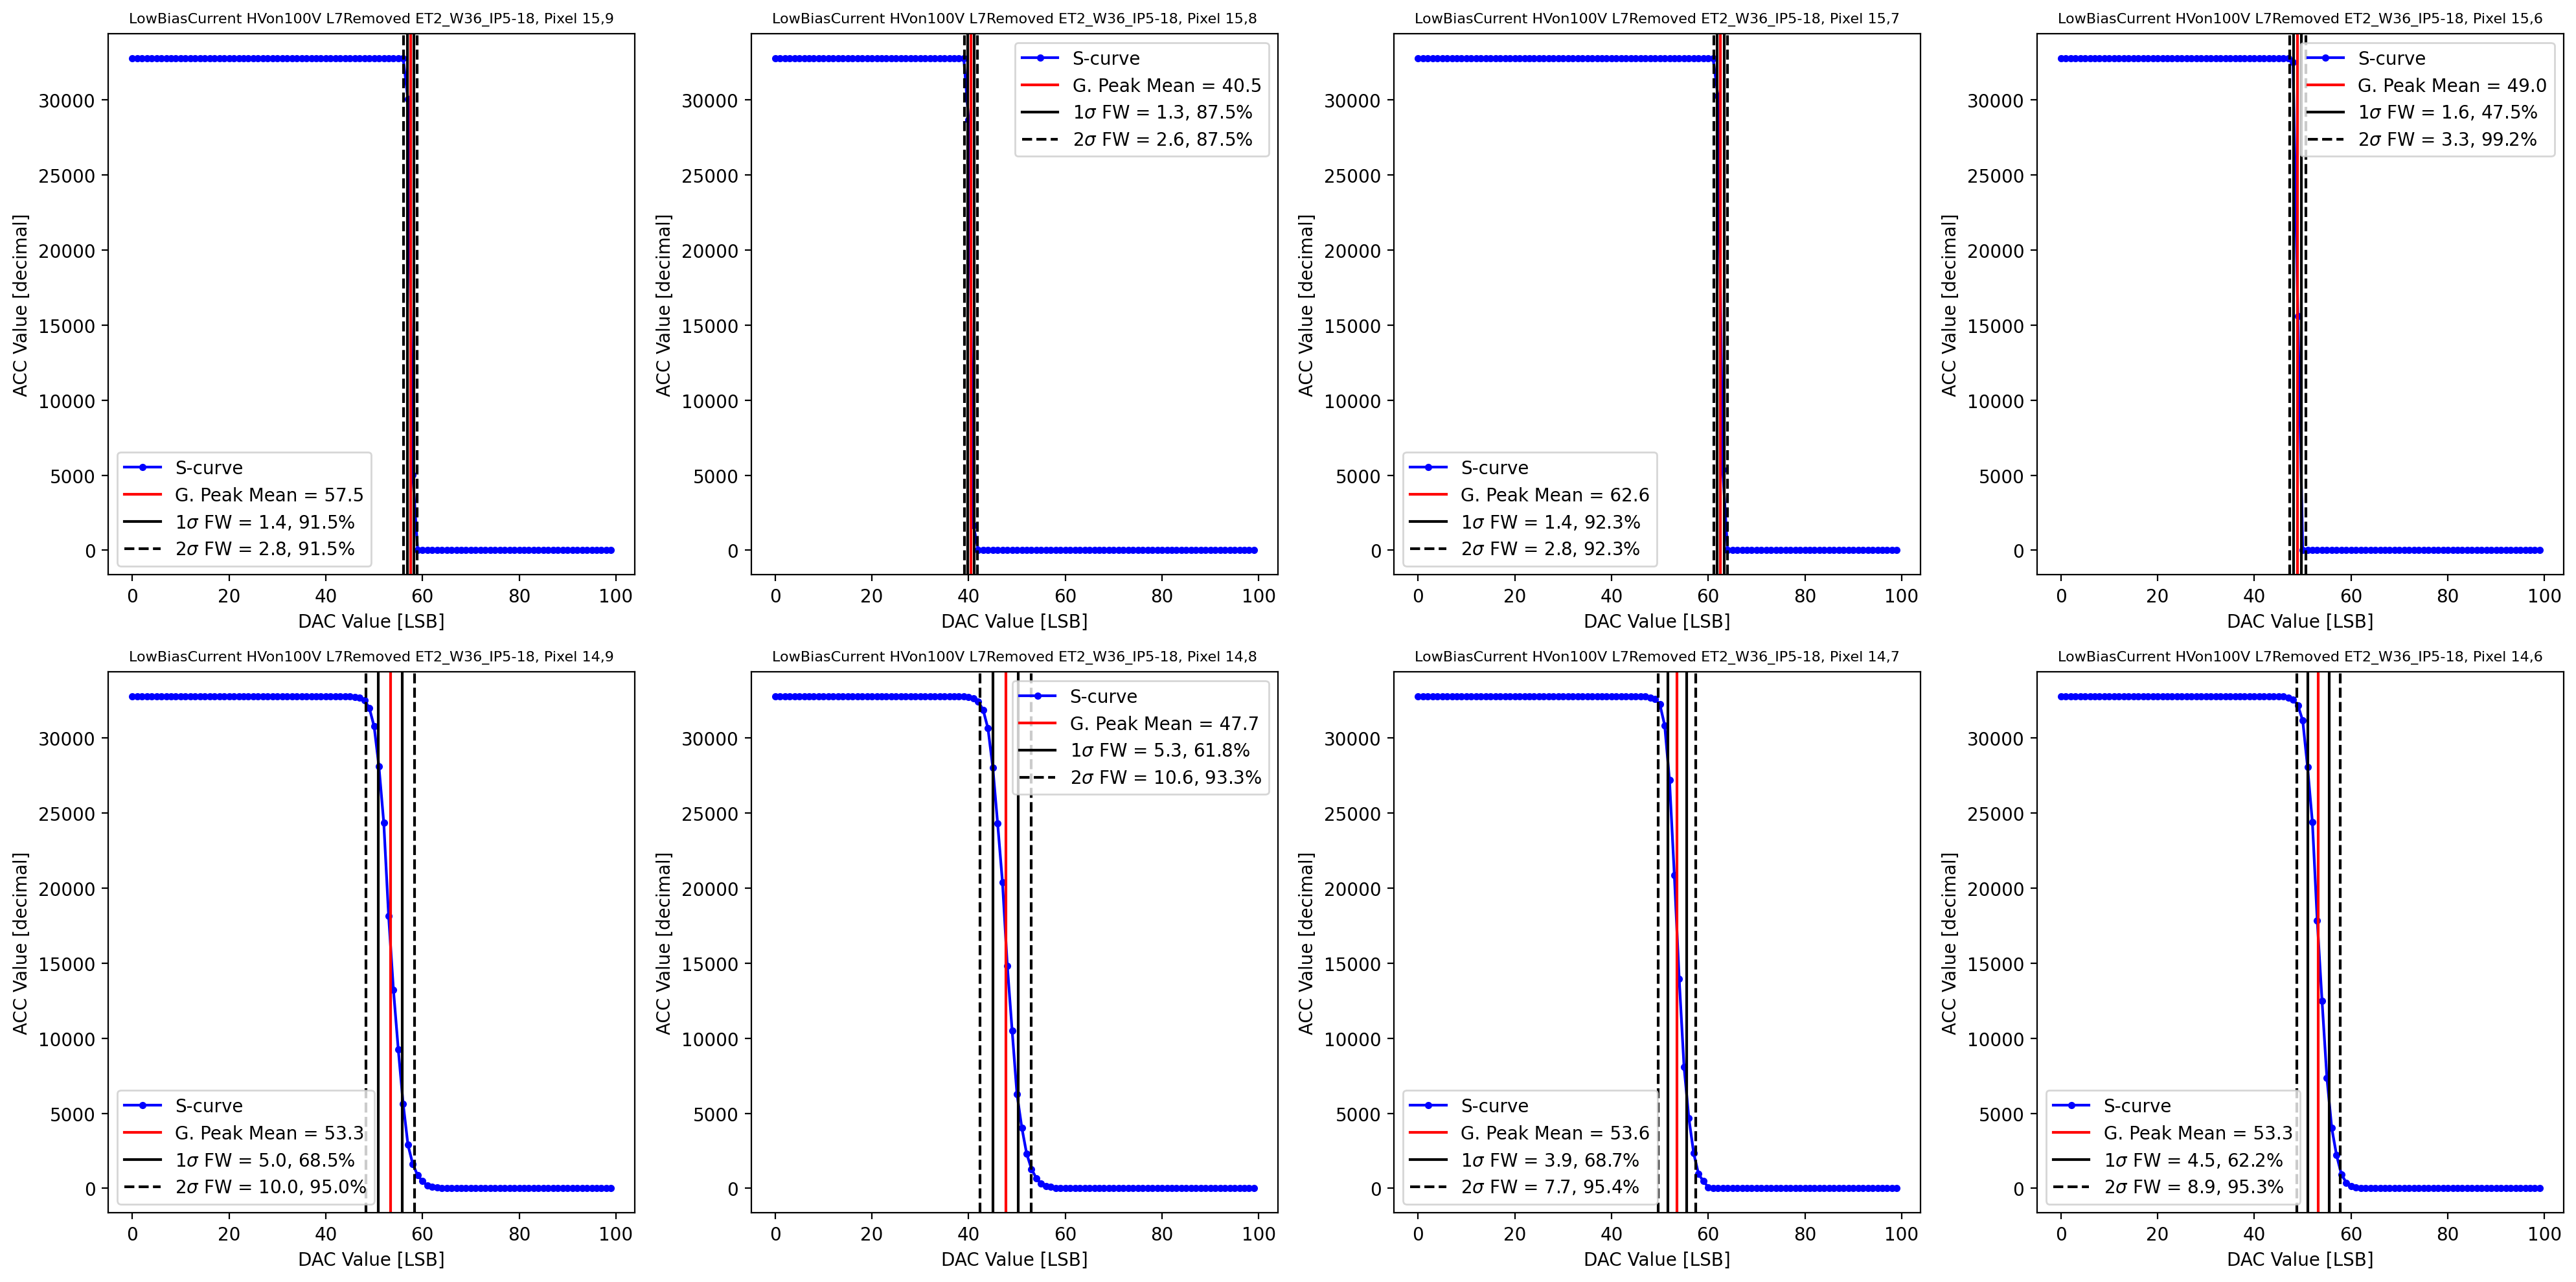

In [19]:
from math import ceil

fig = plt.figure(dpi=200, figsize=(20,10))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
gs = fig.add_gridspec(len(u_rl),len(u_cl))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        y = ACC_map_Scurve[row][col]
        maxcdf = np.amax(y)
        onesigmacdf = y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] - GSigma_map_THCal[row][col]))] - y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] + GSigma_map_THCal[row][col]))]
        twosigmacdf = y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] - 2*GSigma_map_THCal[row][col]))] - y[return_closest_xvalue(x, ceil(GMean_map_THCal[row][col] + 2*GSigma_map_THCal[row][col]))]

        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.plot(DAC_range, ACC_map_Scurve[row][col], 'b.-', label="S-curve")
        ax0.axvline(GMean_map_THCal[row][col], color='r', label=f"G. Peak Mean = {GMean_map_THCal[row][col]:.1f}")
        ax0.axvline(GMean_map_THCal[row][col]+GSigma_map_THCal[row][col], color='k', label=fr"1$\sigma$ FW = {2*GSigma_map_THCal[row][col]:.1f}, {100*onesigmacdf/maxcdf:.1f}%")
        ax0.axvline(GMean_map_THCal[row][col]-GSigma_map_THCal[row][col], color='k')
        ax0.axvline(GMean_map_THCal[row][col]+2*GSigma_map_THCal[row][col], color='k', ls="--", label=fr"2$\sigma$ FW = {4*GSigma_map_THCal[row][col]:.1f}, {100*twosigmacdf/maxcdf:.1f}%")
        ax0.axvline(GMean_map_THCal[row][col]-2*GSigma_map_THCal[row][col], color='k', ls="--")
        ax0.set_xlabel("DAC Value [LSB]")
        ax0.set_ylabel("ACC Value [decimal]")
        plt.legend()
        plt.title(chip_figtitle+f", Pixel {row},{col}", size=8)
plt.tight_layout()
plt.savefig(str(fig_outdir)+"/ACC_Gaussian_SCurve_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")

## Set User defined thresholds from offline gaussian fit

In [ ]:
total_number_pixels = 1
time_per_pixel = 10
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel)

row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

sigmaScan = [i for i in range(6)]
qinjScan  = [0, 8, 10, 15]
ACC_sigmaScn_dict = {i:[] for i in sigmaScan}

for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    pixel_decoded_register_write("Bypass_THCal", "1")
    pixel_decoded_register_write("TH_offset", format(0x0, '06b'))
    pixel_decoded_register_write("disDataReadout", "1")
    pixel_decoded_register_write("QInjEn", "0")
    for Qinj in qinjScan:
        if(Qinj!=0): pixel_decoded_register_write("QSel", format(Qinj, '05b'))
        for i in sigmaScan:
            g_mean  = round(GMean_map_THCal[row][col])
            g_sigma = ceil(GSigma_map_THCal[row][col])
            DAC = int(g_mean+(i*g_sigma))
            pixel_decoded_register_write("disDataReadout", "0")
            if(Qinj!=0): pixel_decoded_register_write("QInjEn", "1")
            pixel_decoded_register_write("DAC", format(DAC, '010b'))
            time.sleep(1)
            scan_name = f"E2_testing_VRef_{chip_figname}_Pixel_C{col}_R{row}_BLplus{i}sigma_Qinj_{Qinj}_Threshold_{DAC}"
            parser = run_script.getOptionParser()
            (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
            process.start()
            if(Qinj!=0): IPC_queue.put('start L1A 1MHz clean')
            else: IPC_queue.put('start L1A 1MHz noQinj')
            while not IPC_queue.empty():
                pass
            time.sleep(time_per_pixel)
            IPC_queue.put('stop DAQ')
            IPC_queue.put('stop L1A 1MHz')
            while not IPC_queue.empty():
                pass
            pixel_decoded_register_write("QInjEn", "0")
            pixel_decoded_register_write("disDataReadout", "1")
            time.sleep(1)
            IPC_queue.put('allow threads to exit')
            process.join()
            time.sleep(1)

# Make Plots (Can be run separately)

In [ ]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from fnmatch import fnmatch
import hist
from hist import Hist

In [ ]:
row_list = [14, 14, 14, 14, 15, 15, 15, 15]
col_list = [6, 7, 8, 9, 6, 7, 8, 9]

scan_list = list(zip(col_list, row_list))
print(scan_list)

In [ ]:
sigmaScan = [i for i in range(6)]
qinjScan  = [0, 8, 10, 15]

In [ ]:
def return_empty_list():
    return {(row,col):{q:{i:0 for i in sigmaScan}for q in qinjScan}for col,row in scan_list}
def return_simple_empty_list():
    return {(row,col):[] for col,row in scan_list}

In [ ]:
h = {(row,col):{q:{i:(
        Hist.new.Integer(100, 200, name="CAL", label="CAL [LSB]")
        .Integer(0, 260, name="TOT", label="TOT [LSB]")
        .Integer(0, 520, name="TOA", label="TOA [LSB]")
        .Double()
      )
      for i in sigmaScan}
     for q in qinjScan}
    for col,row in scan_list}
hit_counts = return_empty_list()

In [ ]:
root = '../ETROC-Data'
file_pattern = "*translated*.dat"
for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
    for Qinj in qinjScan:
        for i in sigmaScan:
            path_pattern = f"*2023-06-22_Array_Test_Results/E2_testing_VRef_{chip_figname}_Pixel_C{col}_R{row}_BLplus{i}sigma_Threshold_[0-9][0-9]_Qinj_{Qinj}"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
                        # print(file_list[-1])
            total_files = len(file_list)
            for file_index, file_name in enumerate(file_list):
                # print(f"{file_index+1}/{total_files}")
                with open(file_name) as infile:
                    for line in infile:
                        text_list = line.split()
                        if text_list[2]!="DATA": continue
                        c_running = int(text_list[6])
                        r_running = int(text_list[8])
                        if(c_running!=col or r_running!=row): continue
                        TOA = int(text_list[10])
                        TOT = int(text_list[12])
                        CAL = int(text_list[14])
                        h[(r_running,c_running)][Qinj][i].fill(CAL,TOT,TOA)
                        hit_counts[(r_running,c_running)][Qinj][i] += 1 

In [ ]:
# fig = plt.figure(dpi=300, figsize=(10,10))
# gs = fig.add_gridspec(1,1)
# ax = fig.add_subplot(gs[0,0])
# ax.set_title(f"Pixel ({row},{col}) CAL (LSB)")
# h[(14,9)][0][0].project("CAL")[0j:300j].plot1d(ax=ax, lw=1)
# ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation='vertical', size=3)
# plt.show()

In [ ]:
for Qinj in qinjScan:
    fig = plt.figure(dpi=300, figsize=(20,10))
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))
    gs = fig.add_gridspec(len(u_rl),len(u_cl))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            for i in sigmaScan:
                h[(row,col)][Qinj][i].project("CAL")[100j:200j].plot1d(ax=ax0, lw=1, label=fr"$\mu$+{i}$\sigma$")
            plt.title(chip_figtitle+f", CAL [LSB], Pixel [{row},{col}], Qinj {Qinj}fC", size=6)
            ax0.set_xticks(ax0.get_xticks()[::2],ax0.get_xticklabels()[::2], rotation='vertical', size=5)
            plt.legend()
    plt.tight_layout()
    plt.savefig(str(fig_outdir)+f"/noiseAnalysis_Qinj_{Qinj}_CAL_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
    plt.close()

In [ ]:
for Qinj in qinjScan:
    fig = plt.figure(dpi=300, figsize=(20,10))
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))
    gs = fig.add_gridspec(len(u_rl),len(u_cl))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            for i in sigmaScan:
                h[(row,col)][Qinj][i].project("TOT").plot1d(ax=ax0, lw=1, label=fr"$\mu$+{i}$\sigma$")
            plt.title(chip_figtitle+f", TOT [LSB], Pixel [{row},{col}], Qinj {Qinj}fC", size=6)
            ax0.set_xticks(ax0.get_xticks()[::4],ax0.get_xticklabels()[::4], rotation='vertical', size=5)
            plt.legend()
    plt.tight_layout()
    plt.savefig(str(fig_outdir)+f"/noiseAnalysis_Qinj_{Qinj}_TOT_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
    plt.close()

In [ ]:
for Qinj in qinjScan:
    fig = plt.figure(dpi=300, figsize=(20,10))
    u_cl = np.sort(np.unique(col_list))
    u_rl = np.sort(np.unique(row_list))
    gs = fig.add_gridspec(len(u_rl),len(u_cl))
    for ri,row in enumerate(u_rl):
        for ci,col in enumerate(u_cl):
            ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
            for i in sigmaScan:
                h[(row,col)][Qinj][i].project("TOA").plot1d(ax=ax0, lw=1, label=fr"$\mu$+{i}$\sigma$")
            plt.title(chip_figtitle+f", TOA [LSB], Pixel [{row},{col}], Qinj {Qinj}fC", size=6)
            ax0.set_xticks(ax0.get_xticks()[::7],ax0.get_xticklabels()[::7], rotation='vertical', size=5)
            plt.legend()
    plt.tight_layout()
    plt.savefig(str(fig_outdir)+f"/noiseAnalysis_Qinj_{Qinj}_TOA_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
    plt.close()

In [ ]:
for Qinj in qinjScan:
    for row,col in zip(row_list, col_list):
        fig = plt.figure(dpi=300, figsize=(15,10))
        gs = fig.add_gridspec(2,3)
        for i in sigmaScan:
            ax = fig.add_subplot(gs[i//3,i%3])
            h[(row,col)][Qinj][i].project("TOA", "TOT").plot2d(
                ax=ax,
                cmap="coolwarm"
            )
            ax.set_xticks(ax.get_xticks()[::7],ax.get_xticklabels()[::7], rotation='vertical', size=5)
            ax.set_yticks(ax.get_yticks()[::4],ax.get_yticklabels()[::4], size=5)
            ax.set_title(chip_figtitle+fr", TOA-TOT, Pixel [{row},{col}], Qinj {Qinj}fC, $\mu$+{i}$\sigma$", size=6)
        plt.tight_layout()
        plt.savefig(str(fig_outdir)+f"/noiseAnalysis_Qinj_{Qinj}_TOA_vs_TOT_Pixel_{row}_{col}_"+chip_figname+"_"+datetime.date.today().isoformat()+".png")
        plt.close()


In [ ]:
# fig = plt.figure(dpi=300, figsize=(160,160))
# gs = fig.add_gridspec(16,16)
# for i in range(16):
#     for j in range(16):
#         print(i,j)
#         if np.isnan(CAL_mean[i,j]): continue
#         ax = fig.add_subplot(gs[15-i,15-j])
#         divider = make_axes_locatable(ax)
#         top_ax = divider.append_axes('top', size='20%', pad=0.1, sharex=ax)
#         side_ax = divider.append_axes('right', size='20%', pad=0.1, sharey=ax)
#         h[i][j].project("TOA", "TOT").plot2d_full(
#             ax_dict = {"main_ax":ax, "top_ax":top_ax, "side_ax":side_ax},
#             main_cmap="coolwarm",
#             top_ls="-",top_color="orange",top_lw=2,
#             side_ls="-",side_lw=2,side_color="steelblue",
#         )
#         ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation='vertical')
#         start, end = side_ax.get_xlim()
#         side_ax.set_xticks(np.linspace(0, end, 3), np.linspace(0, end, 3), rotation='vertical')
#         side_ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
#         top_ax.set_title(f"Pixel ({i},{j}) : TOA vs TOT (LSB)")
# plt.savefig("figures/TOA_vs_TOT_chip.pdf")
# plt.close()

# Disconnect chip

In [20]:
conn.disconnect()